In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lmfit import Minimizer, Parameters
import seaborn as sns

sns.set(color_codes=True, style="white")

## Load Data

In [2]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/distinct_interaction_modes"
os.chdir(folder)

# color_1x = "#808080"
color_1x = "#E88791"
# color_2x = "#000000"
color_2x = "#BD2433"

df_1x = pd.read_csv("colocalization_AIO_concat-FL_1x_100ms.csv")
df_2x = pd.read_csv("colocalization_AIO_concat-FL_2x_100ms.csv")

In [23]:
df_1x.keys()

Index(['filename', 'fname_RNA', 'fname_condensate', 'RNA_trackID', 't', 'x',
       'y', 'InCondensate', 'condensateID', 'R_nm', 'distance_to_center_nm',
       'distance_to_edge_nm'],
      dtype='object')

## Functions

In [3]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)


def get_dwell_times_split(array_in_condensate, array_trackID, array_R_nm):
    threshold_PB_HOPS = 350  # nm
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times_PB = []
    dwell_times_HOPS = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            average_r = np.mean(array_R_nm[change_indices[i] : change_indices[i + 1]])
            if average_r >= threshold_PB_HOPS:
                dwell_times_PB.append(change_indices[i + 1] - change_indices[i])
            else:
                dwell_times_HOPS.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times_PB), np.array(dwell_times_HOPS)


def calc_R2(ydata, yfit):
    # residual sum of squares (ss_tot)
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    # r_squared-value
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


def cdf_lmfit_dual(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    a2 = params["a2"]
    tau1 = params["tau1"]
    tau2 = params["tau2"]
    model = 1 - a1 * np.exp(-t / tau1) - a2 * np.exp(-t / tau2)
    return model - data


def cdf_lmfit_single(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    # a1 = params["a1"]
    tau1 = params["tau1"]
    model = 1 - np.exp(-t / tau1)
    return model - data


def fit_CDF_dual(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0)
    params.add("a2", expr="1-a1")
    params.add("tau1", min=0.03, max=0.5, value=0.1)  # min=ln2/0.1
    params.add("tau2", min=0.5, max=2, value=1)

    # do fit, with the default leastsq algorithm
    minner = Minimizer(cdf_lmfit_dual, params, fcn_args=(bin_centers, cumulative_hist))
    result = minner.minimize()

    a1 = result.params["a1"].value
    a2 = result.params["a2"].value
    tau1 = result.params["tau1"].value
    tau2 = result.params["tau2"].value
    a1_se = result.params["a1"].stderr
    a2_se = result.params["a2"].stderr
    tau1_se = result.params["tau1"].stderr
    tau2_se = result.params["tau2"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    print("a1", a1, a1_se)
    print("tau1", tau1, tau1_se)
    print("a2", a2, a2_se)
    print("tau2", tau2, tau2_se)
    print("R2", R2)

    return {
        "a1": a1,
        "a2": a2,
        "tau1": tau1,
        "tau2": tau2,
        "a1_se": a1_se,
        "a2_se": a2_se,
        "tau1_se": tau1_se,
        "tau2_se": tau2_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def fit_CDF_single(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    # params.add("a1", min=0, max=1, value=0.8)
    params.add("tau1", min=0.03, max=2, value=1)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(
        cdf_lmfit_single, params, fcn_args=(bin_centers, cumulative_hist)
    )
    result = minner.minimize()

    # a1 = result.params["a1"].value
    tau1 = result.params["tau1"].value
    # a1_se = result.params["a1"].stderr
    tau1_se = result.params["tau1"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    # print("a1", a1, a1_se)
    print("tau", tau1, tau1_se)
    print("R2", R2)

    return {
        # "a1": a1,
        "tau": tau1,
        # "a1_se": a1_se,
        "tau_se": tau1_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def count_dwell_events(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )
    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )
    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
    # Calculate the durations of each trajectory, and then all dwell events within
    N_dwell_per_track = []
    for i in range(len(change_indices_trackID) - 1):
        bool_change_indices_condensate_within_track = (
            change_indices_condensate >= change_indices_trackID[i]
        ) & (change_indices_condensate <= change_indices_trackID[i + 1])
        N_dwell_per_track.append(np.sum(bool_change_indices_condensate_within_track))

    return np.array(N_dwell_per_track)


def count_dwell_events_split(array_in_condensate, array_trackID, array_R_nm):
    threshold_PB_HOPS = 350  # nm
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )
    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )
    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
    # Calculate the durations of each trajectory, and then all dwell events within
    N_dwell_per_track_PB = []
    N_dwell_per_track_HOPS = []
    for i in range(len(change_indices_trackID) - 1):
        average_r = np.mean(
            array_R_nm[change_indices_trackID[i] : change_indices_trackID[i + 1]]
        )
        bool_change_indices_condensate_within_track = (
            change_indices_condensate >= change_indices_trackID[i]
        ) & (change_indices_condensate <= change_indices_trackID[i + 1])
        N_dwell_per_track = np.sum(bool_change_indices_condensate_within_track)

        if average_r >= threshold_PB_HOPS:
            N_dwell_per_track_PB.append(N_dwell_per_track)
        else:
            N_dwell_per_track_HOPS.append(N_dwell_per_track)

    return (
        np.array(N_dwell_per_track_PB),
        np.array(N_dwell_per_track_HOPS),
    )

# Interaction (Dwell) Time

## Dwell time distributions 1x vs 2x, no split

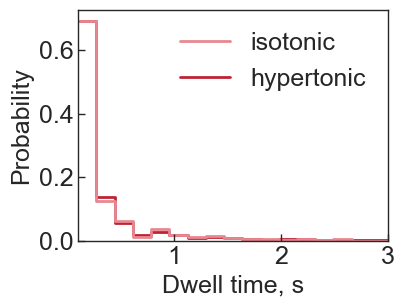

In [4]:
dwell_times_1 = (
    get_dwell_times(df_1x["InCondensate"].to_numpy(), df_1x["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df_2x["InCondensate"].to_numpy(), df_2x["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
data = pd.concat(
    [
        pd.DataFrame({"dwell_time": dwell_times_1, "label": "isotonic"}),
        pd.DataFrame({"dwell_time": dwell_times_2, "label": "hypertonic"}),
    ],
    ignore_index=True,
)

plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    hue_order=['isotonic', 'hypertonic'],
    palette=[color_1x, color_2x],
    bins=17,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    # cumulative=True,
)
plt.xlim(0.1, 3)
sns.move_legend(ax, 1, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-histo-FL_1x_vs_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

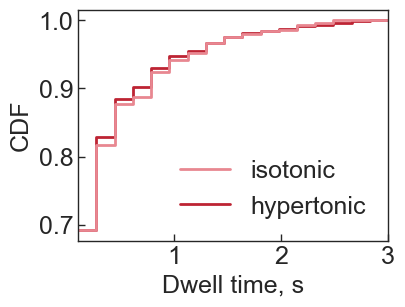

In [5]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    hue_order=['isotonic', 'hypertonic'],
    palette=[color_1x, color_2x],
    bins=17,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
plt.xlim(0.1, 3)
sns.move_legend(
    ax,
    4,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-cdf-FL_1x_vs_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

## Fit to CDF, 1x, 2x, individually, no split

In [6]:
dwell_times_1 = (
    get_dwell_times(df_1x["InCondensate"].to_numpy(), df_1x["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df_2x["InCondensate"].to_numpy(), df_2x["RNA_trackID"].to_numpy()) * 0.1
)  # unit s

In [7]:
print("isotonic")
results_dual_1 = fit_CDF_dual(dwell_times_1)
results_single_1 = fit_CDF_single(dwell_times_1)
print('hypertonic')
results_dual_2 = fit_CDF_dual(dwell_times_2)
results_single_2 = fit_CDF_single(dwell_times_2)

isotonic
a1 0.6348321479415878 0.020487475230096214
tau1 0.1085376885860853 0.005383531035078443
a2 0.3651678520584122 0.02048747521613109
tau2 0.6156511224746645 0.02300774834868336
R2 0.9885256049619209
tau 0.24991755129297816 0.00680440236965716
R2 0.8489013027925603
hypertonic
a1 0.7312617621530586 0.021681485780231335
tau1 0.14383458267247243 0.0061806794457305
a2 0.2687382378469414 0.021681485826740773
tau2 0.6904613639131003 0.04547124906577888
R2 0.985208186307432
tau 0.24778079706085923 0.005828673624179455
R2 0.894669451017305


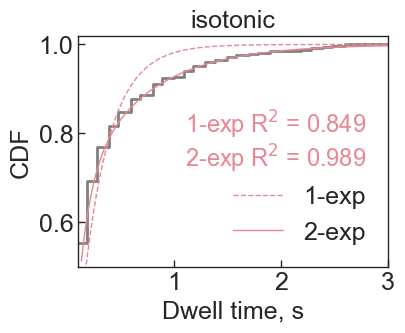

In [8]:
# For first dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_1,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_1["bin_centers"],
    results_single_1["yfit"],
    color=color_1x,
    linestyle="--",
    label="1-exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_1["bin_centers"],
    results_dual_1["yfit"],
    color=color_1x,
    linestyle="-",
    label="2-exp",
    lw=1,
)
# add text
left = 1.1
top = 0.8
gap = 0.075
plt.text(
    left,
    top,
    "1-exp R$^2$ = "
    + "{:.3f}".format(round(results_single_1["R2"], 3)),
    fontsize=17,
    color=color_1x,
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    "2-exp R$^2$ = "
    + "{:.3f}".format(round(results_dual_1["R2"], 3)),
    fontsize=17,
    color=color_1x,
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.ylim(0.5, 1.02)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.title("isotonic", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_1x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

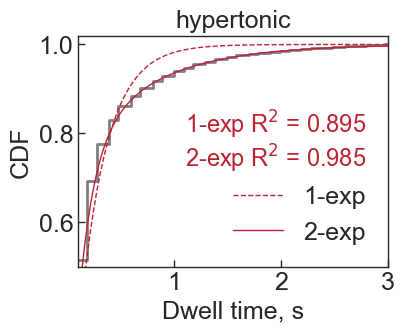

In [9]:
# For second dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_2,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_2["bin_centers"],
    results_single_2["yfit"],
    color=color_2x,
    linestyle="--",
    label="1-exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_2["bin_centers"],
    results_dual_2["yfit"],
    color=color_2x,
    linestyle="-",
    label="2-exp",
    lw=1,
)
# add text
left = 1.1
top = 0.8
gap = 0.075
plt.text(
    left,
    top,
    "1-exp R$^2$ = "
    + "{:.3f}".format(round(results_single_2["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    "2-exp R$^2$ = "
    + "{:.3f}".format(round(results_dual_2["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.ylim(0.5, 1.02)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.title("hypertonic", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

## Fit to CDF, 2x, split PB/HOPS

In [10]:
dwell_times_2x_PB, dwell_times_2x_HOPS = get_dwell_times_split(
    df_2x["InCondensate"].to_numpy(),
    df_2x["RNA_trackID"].to_numpy(),
    df_2x["R_nm"].to_numpy(),
)
dwell_times_2x_PB = dwell_times_2x_PB * 0.1  # unit:F s
dwell_times_2x_HOPS = dwell_times_2x_HOPS * 0.1  # unit: s

In [11]:
print("2x, PB")
results_dual_2x_PB = fit_CDF_dual(dwell_times_2x_PB)
results_single_2x_PB = fit_CDF_single(dwell_times_2x_PB)
print("2x, HOPS")
results_dual_2x_HOPS = fit_CDF_dual(dwell_times_2x_HOPS)
results_single_2x_HOPS = fit_CDF_single(dwell_times_2x_HOPS)

2x, PB
a1 0.6468840860948779 0.02237424378111064
tau1 0.1387313405588678 0.00683719693607943
a2 0.3531159139051221 0.02237424382878207
tau2 0.6924159678174642 0.032747423487136954
R2 0.9886457652385738
tau 0.2865566964143662 0.00711213401572513
R2 0.8846494574149348
2x, HOPS
a1 0.7415297988053378 0.025766644903065964
tau1 0.1438042651747638 0.007084962500965546
a2 0.25847020119466224 0.025766644944501815
tau2 0.6912159897492813 0.04881201479649208
R2 0.984473526101036
tau 0.24097458970992763 0.0055699524187584094
R2 0.898040428437319


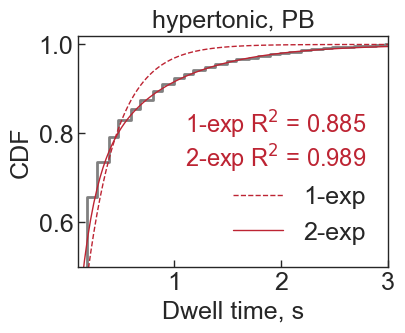

In [12]:
# For 2x, PB
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_2x_PB,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_2x_PB["bin_centers"],
    results_single_2x_PB["yfit"],
    color=color_2x,
    linestyle="--",
    label="1-exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_2x_PB["bin_centers"],
    results_dual_2x_PB["yfit"],
    color=color_2x,
    linestyle="-",
    label="2-exp",
    lw=1,
)
# add text
left = 1.1
top = 0.8
gap = 0.075
plt.text(
    left,
    top,
    "1-exp R$^2$ = "
    + "{:.3f}".format(round(results_single_2x_PB["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    "2-exp R$^2$ = "
    + "{:.3f}".format(round(results_dual_2x_PB["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.ylim(0.5, 1.02)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.title("hypertonic, PB", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_2x_PB.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

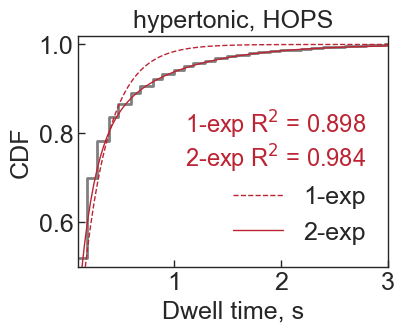

In [13]:
# For 2x, HOPS
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_2x_HOPS,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_2x_HOPS["bin_centers"],
    results_single_2x_HOPS["yfit"],
    color=color_2x,
    linestyle="--",
    label="1-exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_2x_HOPS["bin_centers"],
    results_dual_2x_HOPS["yfit"],
    color=color_2x,
    linestyle="-",
    label="2-exp",
    lw=1,
)
# add text
left = 1.1
top = 0.8
gap = 0.075
plt.text(
    left,
    top,
    "1-exp R$^2$ = "
    + "{:.3f}".format(round(results_single_2x_HOPS["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    "2-exp R$^2$ = "
    + "{:.3f}".format(round(results_dual_2x_HOPS["R2"], 3)),
    fontsize=17,
    color=color_2x,
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.ylim(0.5, 1.02)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.title("hypertonic, HOPS", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_2x_HOPS.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

## barplot A, tau, R2

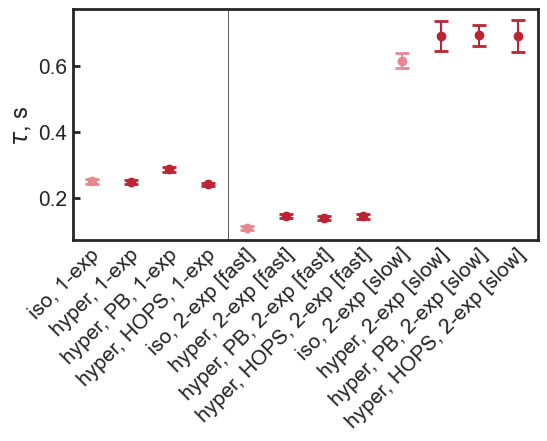

In [22]:
conditions_ordered = [
    "iso, 1-exp",
    "hyper, 1-exp",
    "hyper, PB, 1-exp",
    "hyper, HOPS, 1-exp",
    "iso, 2-exp [fast]",
    "hyper, 2-exp [fast]",
    "hyper, PB, 2-exp [fast]",
    "hyper, HOPS, 2-exp [fast]",
    "iso, 2-exp [slow]",
    "hyper, 2-exp [slow]",
    "hyper, PB, 2-exp [slow]",
    "hyper, HOPS, 2-exp [slow]",
]
lst_tau = [
    results_single_1["tau"],
    results_single_2["tau"],
    results_single_2x_PB["tau"],
    results_single_2x_HOPS["tau"],
    results_dual_1["tau1"],
    results_dual_2["tau1"],
    results_dual_2x_PB["tau1"],
    results_dual_2x_HOPS["tau1"],
    results_dual_1["tau2"],
    results_dual_2["tau2"],
    results_dual_2x_PB["tau2"],
    results_dual_2x_HOPS["tau2"],
]
lst_tau_se = [
    results_single_1["tau_se"],
    results_single_2["tau_se"],
    results_single_2x_PB["tau_se"],
    results_single_2x_HOPS["tau_se"],
    results_dual_1["tau1_se"],
    results_dual_2["tau1_se"],
    results_dual_2x_PB["tau1_se"],
    results_dual_2x_HOPS["tau1_se"],
    results_dual_1["tau2_se"],
    results_dual_2["tau2_se"],
    results_dual_2x_PB["tau2_se"],
    results_dual_2x_HOPS["tau2_se"],
]
colors = [
    color_1x,
    color_2x,
    color_2x,
    color_2x,
    color_1x,
    color_2x,
    color_2x,
    color_2x,
    color_1x,
    color_2x,
    color_2x,
    color_2x,
]

plt.figure(figsize=(6, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[3] + x_pos[4]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_tau[i],
        yerr=lst_tau_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel(r"$\tau$, s", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.savefig(
    "doterrorplot_tau.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

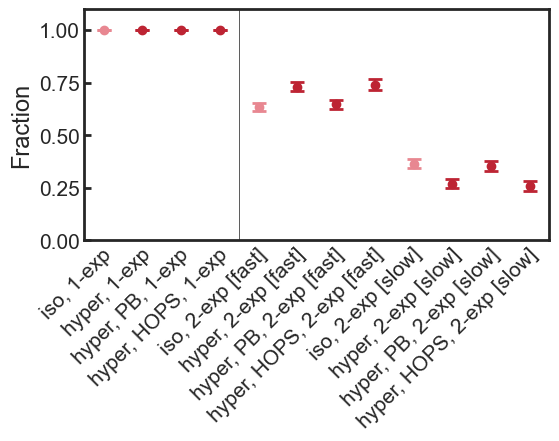

In [15]:
conditions_ordered = [
    "iso, 1-exp",
    "hyper, 1-exp",
    "hyper, PB, 1-exp",
    "hyper, HOPS, 1-exp",
    "iso, 2-exp [fast]",
    "hyper, 2-exp [fast]",
    "hyper, PB, 2-exp [fast]",
    "hyper, HOPS, 2-exp [fast]",
    "iso, 2-exp [slow]",
    "hyper, 2-exp [slow]",
    "hyper, PB, 2-exp [slow]",
    "hyper, HOPS, 2-exp [slow]",
]
lst_frac = [
    1,
    1,
    1,
    1,
    results_dual_1["a1"],
    results_dual_2["a1"],
    results_dual_2x_PB["a1"],
    results_dual_2x_HOPS["a1"],
    results_dual_1["a2"],
    results_dual_2["a2"],
    results_dual_2x_PB["a2"],
    results_dual_2x_HOPS["a2"],
]
lst_frac_se = [
    0,
    0,
    0,
    0,
    results_dual_1["a1_se"],
    results_dual_2["a1_se"],
    results_dual_2x_PB["a1_se"],
    results_dual_2x_HOPS["a1_se"],
    results_dual_1["a2_se"],
    results_dual_2["a2_se"],
    results_dual_2x_PB["a2_se"],
    results_dual_2x_HOPS["a2_se"],
]
colors = [
    color_1x,
    color_2x,
    color_2x,
    color_2x,
    color_1x,
    color_2x,
    color_2x,
    color_2x,
    color_1x,
    color_2x,
    color_2x,
    color_2x,
]

plt.figure(figsize=(6, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[3] + x_pos[4]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_frac[i],
        yerr=lst_frac_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel("Fraction", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.ylim(0, 1.1)
plt.savefig(
    "doterrorplot_frac.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

# Interaction frequency

In [16]:
N_dwell_per_track_1x = count_dwell_events(
    df_1x["InCondensate"].to_numpy(),
    df_1x["RNA_trackID"].to_numpy(),
)

N_dwell_per_track_2x = count_dwell_events(
    df_2x["InCondensate"].to_numpy(),
    df_2x["RNA_trackID"].to_numpy(),
)

N_dwell_per_track_2x_PB, N_dwell_per_track_2x_HOPS = count_dwell_events_split(
    df_2x["InCondensate"].to_numpy(),
    df_2x["RNA_trackID"].to_numpy(),
    df_2x["R_nm"].to_numpy(),
)

In [17]:
def bootstrap_frac(arr):
    arr = arr[arr > 0] # first remove all tracks with no dwell events
    n = round(len(arr) * 0.3)
    f1_samples = []
    f2_samples = []
    f3_samples = []

    for _ in range(1000):
        bootstrap_sample = np.random.choice(arr, size=n, replace=True)
        f1 = np.sum(bootstrap_sample == 1) / n
        f2 = np.sum((bootstrap_sample > 1) & (bootstrap_sample <= 3)) / n
        f3 = np.sum(bootstrap_sample > 3) / n
        f1_samples.append(f1)
        f2_samples.append(f2)
        f3_samples.append(f3)

    f1_mean = np.mean(f1_samples)
    f1_sem = (np.percentile(f1_samples, 95) - np.percentile(f1_samples, 5)) / 2
    f2_mean = np.mean(f2_samples)
    f2_sem = (np.percentile(f2_samples, 95) - np.percentile(f2_samples, 5)) / 2
    f3_mean = np.mean(f3_samples)
    f3_sem = (np.percentile(f3_samples, 95) - np.percentile(f3_samples, 5)) / 2

    return f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem

In [18]:
lst_f1_mean = []
lst_f1_sem = []
lst_f2_mean = []
lst_f2_sem = []
lst_f3_mean = []
lst_f3_sem = []
lst_N = []

input_arrays = [
    N_dwell_per_track_1x,
    N_dwell_per_track_2x,
    N_dwell_per_track_2x_PB,
    N_dwell_per_track_2x_HOPS,
]

for arr in input_arrays:
    f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem = bootstrap_frac(arr)
    lst_f1_mean.append(f1_mean)
    lst_f1_sem.append(f1_sem)
    lst_f2_mean.append(f2_mean)
    lst_f2_sem.append(f2_sem)
    lst_f3_mean.append(f3_mean)
    lst_f3_sem.append(f3_sem)
    lst_N.append(arr[arr > 0].shape[0])

df_fractions = pd.DataFrame(
    {
        "f1_mean": lst_f1_mean,
        "f1_sem": lst_f1_sem,
        "f2_mean": lst_f2_mean,
        "f2_sem": lst_f2_sem,
        "f3_mean": lst_f3_mean,
        "f3_sem": lst_f3_sem,
        "N_dwell_tracks": lst_N,
    },
    dtype=object,
)

In [19]:
df_fractions

,f1_mean,f1_sem,f2_mean,f2_sem,f3_mean,f3_sem,N_dwell_tracks
0,0.461693,0.084158,0.232871,0.064356,0.305436,0.079208,337
1,0.404893,0.014423,0.189099,0.012363,0.406008,0.015282,9708
2,0.09079,0.064516,0.90921,0.064516,0.0,0.0,207
3,0.41057,0.014579,0.174027,0.011412,0.415403,0.014737,9501


In [20]:
N_dwell_per_track_2x_PB[N_dwell_per_track_2x_PB>0].shape

(207,)

f1_mean :
fraction: [46.169306930693075 40.48932005494505 9.079032258064515 41.05701754385965]
SEM: [8.415841584158418 1.4423076923076927 6.451612903225806 1.4578947368421051]

f2_mean :
fraction: [23.287128712871294 18.90989010989011 90.92096774193547 17.402701754385962]
SEM: [6.435643564356434 1.236263736263736 6.451612903225806 1.1412280701754387]

f3_mean :
fraction: [30.54356435643564 40.60078983516483 0.0 41.540280701754384]
SEM: [7.920792079207921 1.5281593406593408 0.0 1.473684210526316]



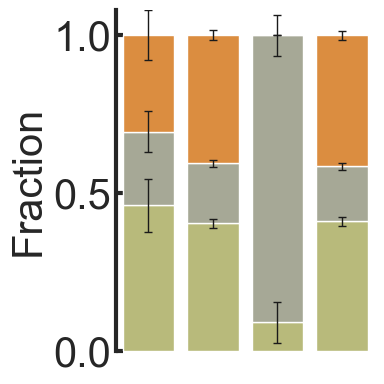

In [21]:
fig = plt.figure(figsize=(4, 4))
x = [1, 2, 3, 4]
colors = [
    "#B8BA7B",
    "#A6A896",
    "#DB8D40",
]

bottom = np.zeros(len(x))
categories = [
    "f1_mean",  # N=1
    "f2_mean",  # 1<N<=3
    "f3_mean",  # 3<N
]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]
plt.ylim(0, 1.08)
plt.ylabel("Fraction", size=30)
plt.xticks([])
plt.yticks([0, 0.5, 1])
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[["right", "top", "bottom"]].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=30,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.5
plt.xlim(1 - canvas_width, 4 + canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig(
    "Fracs_N_dwell_events-split_by_1_3-1x_2x_2xPB_2xHOPS.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)